# Using Indigo for DC Removal in X-Space MPI

Based on Konkle et al. [A Convex Formulation for Magnetic Particle Imaging X-Space Reconstruction](https://doi.org/10.1371/journal.pone.0140137).

## Load example image

Populating the interactive namespace from numpy and matplotlib


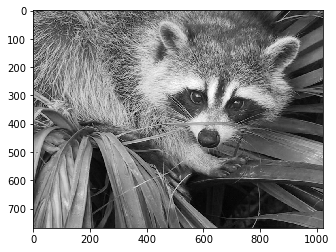

In [1]:
%pylab inline

import logging
import argparse
import numpy as np
from scipy import misc
import scipy.sparse as spp
from contexttimer import Timer

img = misc.face()
img = img[:,:,0] # select one color channel
img = img.astype(np.complex64) # change datatype

plt.imshow(abs(img), cmap='gray', interpolation='none')

## Generate synthetic pFOV data

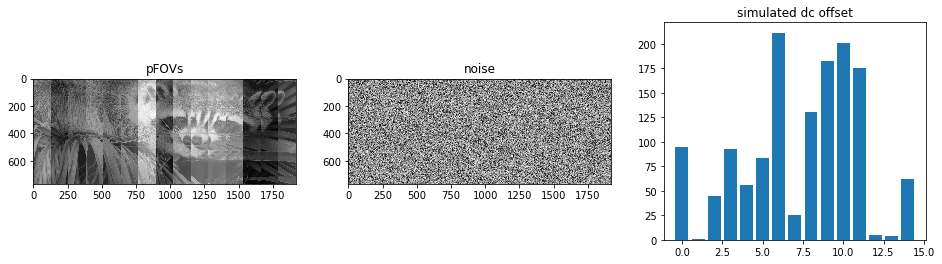

In [2]:
x,z = img.shape
p = width = 128
s = overlap = 32
g = gap = p-2*s
snr = 10

pfovs = np.array([img[:,c:c+p] for c in range(0,z-g,g)])

img_dc = np.mean(abs(img))
dc_offsets = 2*np.random.rand(len(pfovs)) * img_dc
pfovs += dc_offsets[:,None,None]

noise = ((np.random.rand(*pfovs.shape)-0.5) + \
      1j*(np.random.rand(*pfovs.shape)-0.5)) / (2*snr)
pfovs += noise

npf, px, pz = pfovs.shape

fig, (ax0, ax1, ax2) = plt.subplots(1,3,figsize=(16,4))
ax0.set_title("pFOVs")
ax0.imshow( abs(pfovs).transpose(1,0,2).reshape((x,-1)), cmap='gray', interpolation='nearest' )
ax1.set_title("noise")
ax1.imshow( abs(noise).transpose(1,0,2).reshape((x,-1)), cmap='gray', interpolation='nearest' )
ax2.set_title("simulated dc offset")
ax2.bar(range(len(dc_offsets)), dc_offsets)
plt.show()

## Construct Operators

In [3]:
logging.basicConfig(level=10)
log = logging.getLogger("mpi")

# instantiate backend
from indigo.backends import get_backend
from indigo.transforms import *

B = get_backend('cuda') # or numpy, cuda, etc.

# construct segmentation operator
indices = np.arange(img.size).reshape(img.shape)
S_shape = (pfovs.size, img.size)
data = np.ones(pfovs.size, dtype=np.complex64)
rows = np.arange(pfovs.size)
cols = np.array([indices[:,c:c+p] for c in range(0,z-g,g)]).flatten()
SegOp = spp.coo_matrix((data, (rows,cols)), shape=S_shape)
S = B.SpMatrix(SegOp, name='segment')

# construct DC removal operator
D = B.KronI(npf*px, B.Eye(pz) - (1/pz)*B.One((pz,pz)))

# combine operators into forward model
A = D*S

# show operator tree
print(A.dump())

INFO:indigo.backends.cuda:using CUDA device #0


*segment, Product, (1474560, 786432), complex64
|   noname, KronI, (1474560, 1474560), complex64
|   |   +%s*%s*, Sum, (128, 128), complex64
|   |   |   noname, Eye, (128, 128), complex64
|   |   |   %s*%s*, Scale, (128, 128), complex64
|   |   |   |   %s*, Scale, (128, 128), complex64
|   |   |   |   |   noname, One, (128, 128), complex64
|   segment, SpMatrix, (1474560, 786432), complex64



## Solve via conjugate gradient

DEBUG:indigo.backends.backend:dynamically allocating scratch space in shape (1474560, 1)
DEBUG:indigo.util:PROFILE(duration=0.040934, event='onemm', membw_rate=0.28818)
DEBUG:indigo.util:PROFILE(duration=0.00023603, event='axpby', membw_rate=99.956)
DEBUG:indigo.backends.backend:matrix segment has 100% nonzero rows and 100% nonzero columns
DEBUG:indigo.backends.backend:matrix segment supports exwrite: 0
DEBUG:indigo.operators:disallowing exwrite for segment
DEBUG:indigo.util:PROFILE(duration=0.0039153, event='csrmm', forward=False, gflop_rate=1.8831, membw_rate=13.859, shape=(1474560, 1))
DEBUG:indigo.util:PROFILE(duration=0.00029945, event='csrmm', forward=True, gflop_rate=24.621, membw_rate=178.58, shape=(786432, 1))
DEBUG:indigo.util:PROFILE(duration=0.03097, event='onemm', membw_rate=0.3809)
DEBUG:indigo.util:PROFILE(duration=0.00021648, event='axpby', membw_rate=108.98)
DEBUG:indigo.util:PROFILE(duration=0.025736, event='onemm', membw_rate=0.45837)
DEBUG:indigo.util:PROFILE(durati

DEBUG:indigo.util:PROFILE(duration=0.019933, event='onemm', it=7, membw_rate=0.5918)
DEBUG:indigo.util:PROFILE(duration=0.0001812, event='axpby', it=7, membw_rate=130.21)
DEBUG:indigo.util:PROFILE(duration=0.0039432, event='csrmm', forward=False, gflop_rate=1.8697, it=7, membw_rate=13.761, shape=(1474560, 1))
INFO:indigo.backends.backend:iter 7, residual 0.0127948
DEBUG:indigo.util:PROFILE(duration=0.054446, event='iter', it=7)
DEBUG:indigo.util:PROFILE(duration=0.00027442, event='csrmm', forward=True, gflop_rate=26.867, it=8, membw_rate=194.87, shape=(786432, 1))
DEBUG:indigo.util:PROFILE(duration=0.020588, event='onemm', it=8, membw_rate=0.57297)
DEBUG:indigo.util:PROFILE(duration=0.00019312, event='axpby', it=8, membw_rate=122.17)
DEBUG:indigo.util:PROFILE(duration=0.020042, event='onemm', it=8, membw_rate=0.58858)
DEBUG:indigo.util:PROFILE(duration=0.00021625, event='axpby', it=8, membw_rate=109.1)
DEBUG:indigo.util:PROFILE(duration=0.003998, event='csrmm', forward=False, gflop_rat

DEBUG:indigo.util:PROFILE(duration=0.022393, event='onemm', it=16, membw_rate=0.52679)
DEBUG:indigo.util:PROFILE(duration=0.00019932, event='axpby', it=16, membw_rate=118.37)
DEBUG:indigo.util:PROFILE(duration=0.0039589, event='csrmm', forward=False, gflop_rate=1.8623, it=16, membw_rate=13.707, shape=(1474560, 1))
INFO:indigo.backends.backend:iter 16, residual 8.15778e-08
DEBUG:indigo.util:PROFILE(duration=0.059971, event='iter', it=16)
DEBUG:indigo.util:PROFILE(duration=0.00028872, event='csrmm', forward=True, gflop_rate=25.536, it=17, membw_rate=185.22, shape=(786432, 1))
DEBUG:indigo.util:PROFILE(duration=0.020968, event='onemm', it=17, membw_rate=0.56259)
DEBUG:indigo.util:PROFILE(duration=0.00019789, event='axpby', it=17, membw_rate=119.22)
DEBUG:indigo.util:PROFILE(duration=0.020968, event='onemm', it=17, membw_rate=0.56259)
DEBUG:indigo.util:PROFILE(duration=0.00018477, event='axpby', it=17, membw_rate=127.69)
DEBUG:indigo.util:PROFILE(duration=0.0039127, event='csrmm', forward=

reconstruction took 1222 ms


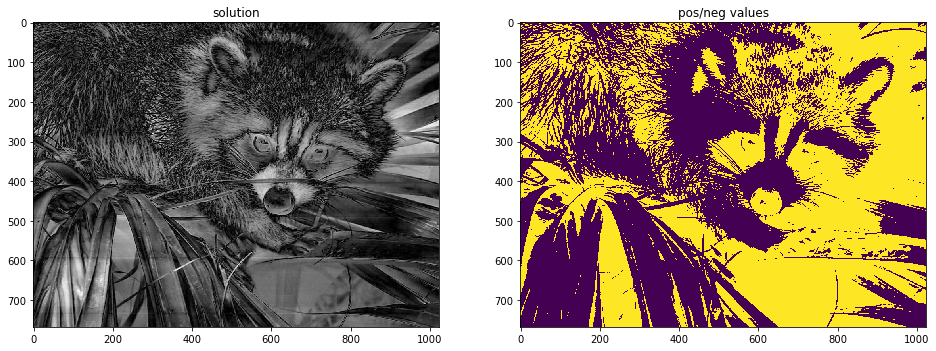

In [4]:
# reshape vectors into 2d fortran-ordered arrays
Y = pfovs.copy().reshape((1,-1)).T
X = np.zeros_like(img).reshape((1,-1)).T

# cg prep
AHy = A.H * Y
AHA = (A.H * A).optimize()

# reconstruct
with Timer() as t:
    B.cg(AHA, AHy, X, maxiter=20)

print("reconstruction took %d ms" % (t.elapsed*1000))

img_rec = X.T.reshape(img.shape)
fig, (ax0, ax1) = plt.subplots(1,2,figsize=(16,16))
ax0.set_title('solution')
ax0.imshow(abs(img_rec), cmap='gray', interpolation='none')
ax1.set_title('pos/neg values')
ax1.imshow(img_rec.real < 0)

## Solve via FISTA

DEBUG:indigo.util:PROFILE(duration=0.00043035, event='csrmm', forward=True, gflop_rate=17.132, it=1, membw_rate=124.27, shape=(786432, 1))
DEBUG:indigo.util:PROFILE(duration=0.039487, event='onemm', it=1, membw_rate=0.29874)
DEBUG:indigo.util:PROFILE(duration=0.00034618, event='axpby', it=1, membw_rate=68.152)
DEBUG:indigo.util:PROFILE(duration=0.031209, event='onemm', it=1, membw_rate=0.37799)
DEBUG:indigo.util:PROFILE(duration=0.00022054, event='axpby', it=1, membw_rate=106.98)
DEBUG:indigo.util:PROFILE(duration=0.0048358, event='csrmm', forward=False, gflop_rate=1.5246, it=1, membw_rate=11.221, shape=(1474560, 1))
DEBUG:indigo.util:PROFILE(duration=0.090095, event='iter', it=1)
INFO:indigo.backends.backend:iter 1
DEBUG:indigo.util:PROFILE(duration=0.00030994, event='csrmm', forward=True, gflop_rate=23.788, it=2, membw_rate=172.54, shape=(786432, 1))
DEBUG:indigo.util:PROFILE(duration=0.027683, event='onemm', it=2, membw_rate=0.42612)
DEBUG:indigo.util:PROFILE(duration=0.00021935, ev

DEBUG:indigo.util:PROFILE(duration=0.00020695, event='axpby', it=10, membw_rate=114)
DEBUG:indigo.util:PROFILE(duration=0.025448, event='onemm', it=10, membw_rate=0.46355)
DEBUG:indigo.util:PROFILE(duration=0.00021315, event='axpby', it=10, membw_rate=110.69)
DEBUG:indigo.util:PROFILE(duration=0.0040672, event='csrmm', forward=False, gflop_rate=1.8128, it=10, membw_rate=13.342, shape=(1474560, 1))
DEBUG:indigo.util:PROFILE(duration=0.065779, event='iter', it=10)
INFO:indigo.backends.backend:iter 10
DEBUG:indigo.util:PROFILE(duration=0.00030041, event='csrmm', forward=True, gflop_rate=24.543, it=11, membw_rate=178.02, shape=(786432, 1))
DEBUG:indigo.util:PROFILE(duration=0.026237, event='onemm', it=11, membw_rate=0.44962)
DEBUG:indigo.util:PROFILE(duration=0.00021362, event='axpby', it=11, membw_rate=110.44)
DEBUG:indigo.util:PROFILE(duration=0.026232, event='onemm', it=11, membw_rate=0.44969)
DEBUG:indigo.util:PROFILE(duration=0.00023055, event='axpby', it=11, membw_rate=102.33)
DEBUG:

DEBUG:indigo.util:PROFILE(duration=0.022404, event='onemm', it=19, membw_rate=0.52653)
DEBUG:indigo.util:PROFILE(duration=0.00021005, event='axpby', it=19, membw_rate=112.32)
DEBUG:indigo.util:PROFILE(duration=0.0039454, event='csrmm', forward=False, gflop_rate=1.8687, it=19, membw_rate=13.754, shape=(1474560, 1))
DEBUG:indigo.util:PROFILE(duration=0.058096, event='iter', it=19)
INFO:indigo.backends.backend:iter 19
DEBUG:indigo.util:PROFILE(duration=0.00031686, event='csrmm', forward=True, gflop_rate=23.268, it=20, membw_rate=168.77, shape=(786432, 1))
DEBUG:indigo.util:PROFILE(duration=0.022097, event='onemm', it=20, membw_rate=0.53384)
DEBUG:indigo.util:PROFILE(duration=0.00019407, event='axpby', it=20, membw_rate=121.57)
DEBUG:indigo.util:PROFILE(duration=0.022285, event='onemm', it=20, membw_rate=0.52936)
DEBUG:indigo.util:PROFILE(duration=0.00019598, event='axpby', it=20, membw_rate=120.38)
DEBUG:indigo.util:PROFILE(duration=0.0039754, event='csrmm', forward=False, gflop_rate=1.85

DEBUG:indigo.util:PROFILE(duration=0.0039961, event='csrmm', forward=False, gflop_rate=1.845, it=28, membw_rate=13.579, shape=(1474560, 1))
DEBUG:indigo.util:PROFILE(duration=0.056968, event='iter', it=28)
INFO:indigo.backends.backend:iter 28
DEBUG:indigo.util:PROFILE(duration=0.00030088, event='csrmm', forward=True, gflop_rate=24.504, it=29, membw_rate=177.73, shape=(786432, 1))
DEBUG:indigo.util:PROFILE(duration=0.021521, event='onemm', it=29, membw_rate=0.54813)
DEBUG:indigo.util:PROFILE(duration=0.00020838, event='axpby', it=29, membw_rate=113.22)
DEBUG:indigo.util:PROFILE(duration=0.021395, event='onemm', it=29, membw_rate=0.55135)
DEBUG:indigo.util:PROFILE(duration=0.00024366, event='axpby', it=29, membw_rate=96.826)
DEBUG:indigo.util:PROFILE(duration=0.0040343, event='csrmm', forward=False, gflop_rate=1.8275, it=29, membw_rate=13.451, shape=(1474560, 1))
DEBUG:indigo.util:PROFILE(duration=0.057563, event='iter', it=29)
INFO:indigo.backends.backend:iter 29
DEBUG:indigo.util:PROFI

INFO:indigo.backends.backend:iter 37
DEBUG:indigo.util:PROFILE(duration=0.00031972, event='csrmm', forward=True, gflop_rate=23.06, it=38, membw_rate=167.26, shape=(786432, 1))
DEBUG:indigo.util:PROFILE(duration=0.022107, event='onemm', it=38, membw_rate=0.5336)
DEBUG:indigo.util:PROFILE(duration=0.00019908, event='axpby', it=38, membw_rate=118.51)
DEBUG:indigo.util:PROFILE(duration=0.022286, event='onemm', it=38, membw_rate=0.52932)
DEBUG:indigo.util:PROFILE(duration=0.00019574, event='axpby', it=38, membw_rate=120.53)
DEBUG:indigo.util:PROFILE(duration=0.0040333, event='csrmm', forward=False, gflop_rate=1.828, it=38, membw_rate=13.454, shape=(1474560, 1))
DEBUG:indigo.util:PROFILE(duration=0.058384, event='iter', it=38)
INFO:indigo.backends.backend:iter 38
DEBUG:indigo.util:PROFILE(duration=0.00030756, event='csrmm', forward=True, gflop_rate=23.972, it=39, membw_rate=173.88, shape=(786432, 1))
DEBUG:indigo.util:PROFILE(duration=0.021878, event='onemm', it=39, membw_rate=0.5392)
DEBUG:

DEBUG:indigo.util:PROFILE(duration=0.022063, event='onemm', it=47, membw_rate=0.53468)
DEBUG:indigo.util:PROFILE(duration=0.00018787, event='axpby', it=47, membw_rate=125.58)
DEBUG:indigo.util:PROFILE(duration=0.022038, event='onemm', it=47, membw_rate=0.53527)
DEBUG:indigo.util:PROFILE(duration=0.00023389, event='axpby', it=47, membw_rate=100.87)
DEBUG:indigo.util:PROFILE(duration=0.0040166, event='csrmm', forward=False, gflop_rate=1.8356, it=47, membw_rate=13.51, shape=(1474560, 1))
DEBUG:indigo.util:PROFILE(duration=0.058078, event='iter', it=47)
INFO:indigo.backends.backend:iter 47
DEBUG:indigo.util:PROFILE(duration=0.00028467, event='csrmm', forward=True, gflop_rate=25.899, it=48, membw_rate=187.86, shape=(786432, 1))
DEBUG:indigo.util:PROFILE(duration=0.022355, event='onemm', it=48, membw_rate=0.52769)
DEBUG:indigo.util:PROFILE(duration=0.00019503, event='axpby', it=48, membw_rate=120.97)
DEBUG:indigo.util:PROFILE(duration=0.022335, event='onemm', it=48, membw_rate=0.52816)
DEBUG

DEBUG:indigo.util:PROFILE(duration=0.00019574, event='axpby', it=56, membw_rate=120.53)
DEBUG:indigo.util:PROFILE(duration=0.022088, event='onemm', it=56, membw_rate=0.53408)
DEBUG:indigo.util:PROFILE(duration=0.00019646, event='axpby', it=56, membw_rate=120.09)
DEBUG:indigo.util:PROFILE(duration=0.003947, event='csrmm', forward=False, gflop_rate=1.8679, it=56, membw_rate=13.748, shape=(1474560, 1))
DEBUG:indigo.util:PROFILE(duration=0.057949, event='iter', it=56)
INFO:indigo.backends.backend:iter 56
DEBUG:indigo.util:PROFILE(duration=0.00028682, event='csrmm', forward=True, gflop_rate=25.706, it=57, membw_rate=186.45, shape=(786432, 1))
DEBUG:indigo.util:PROFILE(duration=0.022653, event='onemm', it=57, membw_rate=0.52075)
DEBUG:indigo.util:PROFILE(duration=0.00019479, event='axpby', it=57, membw_rate=121.12)
DEBUG:indigo.util:PROFILE(duration=0.022721, event='onemm', it=57, membw_rate=0.51918)
DEBUG:indigo.util:PROFILE(duration=0.00021768, event='axpby', it=57, membw_rate=108.39)
DEBU

DEBUG:indigo.util:PROFILE(duration=0.021467, event='onemm', it=65, membw_rate=0.54952)
DEBUG:indigo.util:PROFILE(duration=0.00020599, event='axpby', it=65, membw_rate=114.53)
DEBUG:indigo.util:PROFILE(duration=0.0040295, event='csrmm', forward=False, gflop_rate=1.8297, it=65, membw_rate=13.467, shape=(1474560, 1))
DEBUG:indigo.util:PROFILE(duration=0.057301, event='iter', it=65)
INFO:indigo.backends.backend:iter 65
DEBUG:indigo.util:PROFILE(duration=0.0002861, event='csrmm', forward=True, gflop_rate=25.77, it=66, membw_rate=186.92, shape=(786432, 1))
DEBUG:indigo.util:PROFILE(duration=0.02123, event='onemm', it=66, membw_rate=0.55564)
DEBUG:indigo.util:PROFILE(duration=0.00018859, event='axpby', it=66, membw_rate=125.1)
DEBUG:indigo.util:PROFILE(duration=0.021282, event='onemm', it=66, membw_rate=0.5543)
DEBUG:indigo.util:PROFILE(duration=0.00026083, event='axpby', it=66, membw_rate=90.453)
DEBUG:indigo.util:PROFILE(duration=0.0040236, event='csrmm', forward=False, gflop_rate=1.8324, i

DEBUG:indigo.util:PROFILE(duration=0.0040743, event='csrmm', forward=False, gflop_rate=1.8096, it=74, membw_rate=13.318, shape=(1474560, 1))
DEBUG:indigo.util:PROFILE(duration=0.069441, event='iter', it=74)
INFO:indigo.backends.backend:iter 74
DEBUG:indigo.util:PROFILE(duration=0.00029612, event='csrmm', forward=True, gflop_rate=24.898, it=75, membw_rate=180.6, shape=(786432, 1))
DEBUG:indigo.util:PROFILE(duration=0.026796, event='onemm', it=75, membw_rate=0.44023)
DEBUG:indigo.util:PROFILE(duration=0.000211, event='axpby', it=75, membw_rate=111.81)
DEBUG:indigo.util:PROFILE(duration=0.026605, event='onemm', it=75, membw_rate=0.44339)
DEBUG:indigo.util:PROFILE(duration=0.00021386, event='axpby', it=75, membw_rate=110.32)
DEBUG:indigo.util:PROFILE(duration=0.004092, event='csrmm', forward=False, gflop_rate=1.8018, it=75, membw_rate=13.261, shape=(1474560, 1))
DEBUG:indigo.util:PROFILE(duration=0.067767, event='iter', it=75)
INFO:indigo.backends.backend:iter 75
DEBUG:indigo.util:PROFILE(

INFO:indigo.backends.backend:iter 83
DEBUG:indigo.util:PROFILE(duration=0.00029516, event='csrmm', forward=True, gflop_rate=24.979, it=84, membw_rate=181.18, shape=(786432, 1))
DEBUG:indigo.util:PROFILE(duration=0.020416, event='onemm', it=84, membw_rate=0.57781)
DEBUG:indigo.util:PROFILE(duration=0.00021315, event='axpby', it=84, membw_rate=110.69)
DEBUG:indigo.util:PROFILE(duration=0.020963, event='onemm', it=84, membw_rate=0.56274)
DEBUG:indigo.util:PROFILE(duration=0.00018454, event='axpby', it=84, membw_rate=127.85)
DEBUG:indigo.util:PROFILE(duration=0.0038652, event='csrmm', forward=False, gflop_rate=1.9075, it=84, membw_rate=14.039, shape=(1474560, 1))
DEBUG:indigo.util:PROFILE(duration=0.05431, event='iter', it=84)
INFO:indigo.backends.backend:iter 84
DEBUG:indigo.util:PROFILE(duration=0.00028419, event='csrmm', forward=True, gflop_rate=25.943, it=85, membw_rate=188.17, shape=(786432, 1))
DEBUG:indigo.util:PROFILE(duration=0.020462, event='onemm', it=85, membw_rate=0.5765)
DEBU

DEBUG:indigo.util:PROFILE(duration=0.020506, event='onemm', it=93, membw_rate=0.57527)
DEBUG:indigo.util:PROFILE(duration=0.00018358, event='axpby', it=93, membw_rate=128.51)
DEBUG:indigo.util:PROFILE(duration=0.0205, event='onemm', it=93, membw_rate=0.57544)
DEBUG:indigo.util:PROFILE(duration=0.00018716, event='axpby', it=93, membw_rate=126.06)
DEBUG:indigo.util:PROFILE(duration=0.0038559, event='csrmm', forward=False, gflop_rate=1.9121, it=93, membw_rate=14.073, shape=(1474560, 1))
DEBUG:indigo.util:PROFILE(duration=0.054193, event='iter', it=93)
INFO:indigo.backends.backend:iter 93
DEBUG:indigo.util:PROFILE(duration=0.00027514, event='csrmm', forward=True, gflop_rate=26.797, it=94, membw_rate=194.37, shape=(786432, 1))
DEBUG:indigo.util:PROFILE(duration=0.020507, event='onemm', it=94, membw_rate=0.57523)
DEBUG:indigo.util:PROFILE(duration=0.00018454, event='axpby', it=94, membw_rate=127.85)
DEBUG:indigo.util:PROFILE(duration=0.020461, event='onemm', it=94, membw_rate=0.57653)
DEBUG:

DEBUG:indigo.util:PROFILE(duration=0.00020266, event='axpby', it=102, membw_rate=116.42)
DEBUG:indigo.util:PROFILE(duration=0.025414, event='onemm', it=102, membw_rate=0.46417)
DEBUG:indigo.util:PROFILE(duration=0.00035548, event='axpby', it=102, membw_rate=66.369)
DEBUG:indigo.util:PROFILE(duration=0.0040748, event='csrmm', forward=False, gflop_rate=1.8094, it=102, membw_rate=13.317, shape=(1474560, 1))
DEBUG:indigo.util:PROFILE(duration=0.065004, event='iter', it=102)
INFO:indigo.backends.backend:iter 102
DEBUG:indigo.util:PROFILE(duration=0.0002923, event='csrmm', forward=True, gflop_rate=25.223, it=103, membw_rate=182.95, shape=(786432, 1))
DEBUG:indigo.util:PROFILE(duration=0.026127, event='onemm', it=103, membw_rate=0.45151)
DEBUG:indigo.util:PROFILE(duration=0.00020909, event='axpby', it=103, membw_rate=112.83)
DEBUG:indigo.util:PROFILE(duration=0.026399, event='onemm', it=103, membw_rate=0.44685)
DEBUG:indigo.util:PROFILE(duration=0.00024009, event='axpby', it=103, membw_rate=9

DEBUG:indigo.util:PROFILE(duration=0.030275, event='onemm', it=111, membw_rate=0.38964)
DEBUG:indigo.util:PROFILE(duration=0.00022006, event='axpby', it=111, membw_rate=107.21)
DEBUG:indigo.util:PROFILE(duration=0.0041387, event='csrmm', forward=False, gflop_rate=1.7814, it=111, membw_rate=13.111, shape=(1474560, 1))
DEBUG:indigo.util:PROFILE(duration=0.079771, event='iter', it=111)
INFO:indigo.backends.backend:iter 111
DEBUG:indigo.util:PROFILE(duration=0.00029707, event='csrmm', forward=True, gflop_rate=24.818, it=112, membw_rate=180.02, shape=(786432, 1))
DEBUG:indigo.util:PROFILE(duration=0.027267, event='onemm', it=112, membw_rate=0.43263)
DEBUG:indigo.util:PROFILE(duration=0.00021815, event='axpby', it=112, membw_rate=108.15)
DEBUG:indigo.util:PROFILE(duration=0.026998, event='onemm', it=112, membw_rate=0.43694)
DEBUG:indigo.util:PROFILE(duration=0.00021768, event='axpby', it=112, membw_rate=108.39)
DEBUG:indigo.util:PROFILE(duration=0.0041611, event='csrmm', forward=False, gflop

DEBUG:indigo.util:PROFILE(duration=0.0040982, event='csrmm', forward=False, gflop_rate=1.799, it=120, membw_rate=13.241, shape=(1474560, 1))
DEBUG:indigo.util:PROFILE(duration=0.070338, event='iter', it=120)
INFO:indigo.backends.backend:iter 120
DEBUG:indigo.util:PROFILE(duration=0.00039697, event='csrmm', forward=True, gflop_rate=18.573, it=121, membw_rate=134.71, shape=(786432, 1))
DEBUG:indigo.util:PROFILE(duration=0.031867, event='onemm', it=121, membw_rate=0.37018)
DEBUG:indigo.util:PROFILE(duration=0.00021553, event='axpby', it=121, membw_rate=109.46)
DEBUG:indigo.util:PROFILE(duration=0.023304, event='onemm', it=121, membw_rate=0.50619)
DEBUG:indigo.util:PROFILE(duration=0.00019193, event='axpby', it=121, membw_rate=122.93)
DEBUG:indigo.util:PROFILE(duration=0.0039852, event='csrmm', forward=False, gflop_rate=1.8501, it=121, membw_rate=13.616, shape=(1474560, 1))
DEBUG:indigo.util:PROFILE(duration=0.070926, event='iter', it=121)
INFO:indigo.backends.backend:iter 121
DEBUG:indigo

DEBUG:indigo.util:PROFILE(duration=0.055762, event='iter', it=129)
INFO:indigo.backends.backend:iter 129
DEBUG:indigo.util:PROFILE(duration=0.00029492, event='csrmm', forward=True, gflop_rate=24.999, it=130, membw_rate=181.33, shape=(786432, 1))
DEBUG:indigo.util:PROFILE(duration=0.022408, event='onemm', it=130, membw_rate=0.52643)
DEBUG:indigo.util:PROFILE(duration=0.00034189, event='axpby', it=130, membw_rate=69.007)
DEBUG:indigo.util:PROFILE(duration=0.021899, event='onemm', it=130, membw_rate=0.53867)
DEBUG:indigo.util:PROFILE(duration=0.00024319, event='axpby', it=130, membw_rate=97.016)
DEBUG:indigo.util:PROFILE(duration=0.0039961, event='csrmm', forward=False, gflop_rate=1.845, it=130, membw_rate=13.579, shape=(1474560, 1))
DEBUG:indigo.util:PROFILE(duration=0.056801, event='iter', it=130)
INFO:indigo.backends.backend:iter 130
DEBUG:indigo.util:PROFILE(duration=0.00028205, event='csrmm', forward=True, gflop_rate=26.14, it=131, membw_rate=189.6, shape=(786432, 1))
DEBUG:indigo.ut

DEBUG:indigo.util:PROFILE(duration=0.00027442, event='csrmm', forward=True, gflop_rate=26.867, it=139, membw_rate=194.87, shape=(786432, 1))
DEBUG:indigo.util:PROFILE(duration=0.021063, event='onemm', it=139, membw_rate=0.56006)
DEBUG:indigo.util:PROFILE(duration=0.00021195, event='axpby', it=139, membw_rate=111.31)
DEBUG:indigo.util:PROFILE(duration=0.021335, event='onemm', it=139, membw_rate=0.55291)
DEBUG:indigo.util:PROFILE(duration=0.00021553, event='axpby', it=139, membw_rate=109.46)
DEBUG:indigo.util:PROFILE(duration=0.0040445, event='csrmm', forward=False, gflop_rate=1.8229, it=139, membw_rate=13.417, shape=(1474560, 1))
DEBUG:indigo.util:PROFILE(duration=0.056074, event='iter', it=139)
INFO:indigo.backends.backend:iter 139
DEBUG:indigo.util:PROFILE(duration=0.00028062, event='csrmm', forward=True, gflop_rate=26.273, it=140, membw_rate=190.57, shape=(786432, 1))
DEBUG:indigo.util:PROFILE(duration=0.021557, event='onemm', it=140, membw_rate=0.54723)
DEBUG:indigo.util:PROFILE(dur

DEBUG:indigo.util:PROFILE(duration=0.025607, event='onemm', it=148, membw_rate=0.46067)
DEBUG:indigo.util:PROFILE(duration=0.00025201, event='axpby', it=148, membw_rate=93.62)
DEBUG:indigo.util:PROFILE(duration=0.02533, event='onemm', it=148, membw_rate=0.46571)
DEBUG:indigo.util:PROFILE(duration=0.00020194, event='axpby', it=148, membw_rate=116.83)
DEBUG:indigo.util:PROFILE(duration=0.004055, event='csrmm', forward=False, gflop_rate=1.8182, it=148, membw_rate=13.382, shape=(1474560, 1))
DEBUG:indigo.util:PROFILE(duration=0.065142, event='iter', it=148)
INFO:indigo.backends.backend:iter 148
DEBUG:indigo.util:PROFILE(duration=0.00028753, event='csrmm', forward=True, gflop_rate=25.642, it=149, membw_rate=185.99, shape=(786432, 1))
DEBUG:indigo.util:PROFILE(duration=0.026203, event='onemm', it=149, membw_rate=0.45019)
DEBUG:indigo.util:PROFILE(duration=0.00020123, event='axpby', it=149, membw_rate=117.25)
DEBUG:indigo.util:PROFILE(duration=0.025782, event='onemm', it=149, membw_rate=0.457

DEBUG:indigo.util:PROFILE(duration=0.00019026, event='axpby', it=157, membw_rate=124.01)
DEBUG:indigo.util:PROFILE(duration=0.020661, event='onemm', it=157, membw_rate=0.57095)
DEBUG:indigo.util:PROFILE(duration=0.00018024, event='axpby', it=157, membw_rate=130.89)
DEBUG:indigo.util:PROFILE(duration=0.003933, event='csrmm', forward=False, gflop_rate=1.8746, it=157, membw_rate=13.797, shape=(1474560, 1))
DEBUG:indigo.util:PROFILE(duration=0.056015, event='iter', it=157)
INFO:indigo.backends.backend:iter 157
DEBUG:indigo.util:PROFILE(duration=0.00028896, event='csrmm', forward=True, gflop_rate=25.515, it=158, membw_rate=185.07, shape=(786432, 1))
DEBUG:indigo.util:PROFILE(duration=0.020814, event='onemm', it=158, membw_rate=0.56676)
DEBUG:indigo.util:PROFILE(duration=0.00017786, event='axpby', it=158, membw_rate=132.65)
DEBUG:indigo.util:PROFILE(duration=0.02096, event='onemm', it=158, membw_rate=0.56281)
DEBUG:indigo.util:PROFILE(duration=0.00021434, event='axpby', it=158, membw_rate=11

DEBUG:indigo.util:PROFILE(duration=0.021115, event='onemm', it=166, membw_rate=0.55869)
DEBUG:indigo.util:PROFILE(duration=0.00017953, event='axpby', it=166, membw_rate=131.42)
DEBUG:indigo.util:PROFILE(duration=0.0039546, event='csrmm', forward=False, gflop_rate=1.8643, it=166, membw_rate=13.722, shape=(1474560, 1))
DEBUG:indigo.util:PROFILE(duration=0.055464, event='iter', it=166)
INFO:indigo.backends.backend:iter 166
DEBUG:indigo.util:PROFILE(duration=0.00031066, event='csrmm', forward=True, gflop_rate=23.733, it=167, membw_rate=172.14, shape=(786432, 1))
DEBUG:indigo.util:PROFILE(duration=0.021099, event='onemm', it=167, membw_rate=0.55911)
DEBUG:indigo.util:PROFILE(duration=0.00017452, event='axpby', it=167, membw_rate=135.19)
DEBUG:indigo.util:PROFILE(duration=0.021039, event='onemm', it=167, membw_rate=0.56068)
DEBUG:indigo.util:PROFILE(duration=0.00022912, event='axpby', it=167, membw_rate=102.97)
DEBUG:indigo.util:PROFILE(duration=0.0039763, event='csrmm', forward=False, gflop

DEBUG:indigo.util:PROFILE(duration=0.00019789, event='axpby', it=175, membw_rate=119.22)
DEBUG:indigo.util:PROFILE(duration=0.0040159, event='csrmm', forward=False, gflop_rate=1.8359, it=175, membw_rate=13.512, shape=(1474560, 1))
DEBUG:indigo.util:PROFILE(duration=0.056675, event='iter', it=175)
INFO:indigo.backends.backend:iter 175
DEBUG:indigo.util:PROFILE(duration=0.00029278, event='csrmm', forward=True, gflop_rate=25.182, it=176, membw_rate=182.66, shape=(786432, 1))
DEBUG:indigo.util:PROFILE(duration=0.021025, event='onemm', it=176, membw_rate=0.56106)
DEBUG:indigo.util:PROFILE(duration=0.00022268, event='axpby', it=176, membw_rate=105.95)
DEBUG:indigo.util:PROFILE(duration=0.020752, event='onemm', it=176, membw_rate=0.56846)
DEBUG:indigo.util:PROFILE(duration=0.00019622, event='axpby', it=176, membw_rate=120.24)
DEBUG:indigo.util:PROFILE(duration=0.0040333, event='csrmm', forward=False, gflop_rate=1.828, it=176, membw_rate=13.454, shape=(1474560, 1))
DEBUG:indigo.util:PROFILE(du

DEBUG:indigo.util:PROFILE(duration=0.0039246, event='csrmm', forward=False, gflop_rate=1.8786, it=184, membw_rate=13.827, shape=(1474560, 1))
DEBUG:indigo.util:PROFILE(duration=0.055306, event='iter', it=184)
INFO:indigo.backends.backend:iter 184
DEBUG:indigo.util:PROFILE(duration=0.00030828, event='csrmm', forward=True, gflop_rate=23.916, it=185, membw_rate=173.47, shape=(786432, 1))
DEBUG:indigo.util:PROFILE(duration=0.021035, event='onemm', it=185, membw_rate=0.56081)
DEBUG:indigo.util:PROFILE(duration=0.00022292, event='axpby', it=185, membw_rate=105.84)
DEBUG:indigo.util:PROFILE(duration=0.021548, event='onemm', it=185, membw_rate=0.54746)
DEBUG:indigo.util:PROFILE(duration=0.00023389, event='axpby', it=185, membw_rate=100.87)
DEBUG:indigo.util:PROFILE(duration=0.0039587, event='csrmm', forward=False, gflop_rate=1.8624, it=185, membw_rate=13.707, shape=(1474560, 1))
DEBUG:indigo.util:PROFILE(duration=0.056852, event='iter', it=185)
INFO:indigo.backends.backend:iter 185
DEBUG:indig

DEBUG:indigo.util:PROFILE(duration=0.057571, event='iter', it=193)
INFO:indigo.backends.backend:iter 193
DEBUG:indigo.util:PROFILE(duration=0.00028849, event='csrmm', forward=True, gflop_rate=25.557, it=194, membw_rate=185.37, shape=(786432, 1))
DEBUG:indigo.util:PROFILE(duration=0.021818, event='onemm', it=194, membw_rate=0.54068)
DEBUG:indigo.util:PROFILE(duration=0.00021076, event='axpby', it=194, membw_rate=111.94)
DEBUG:indigo.util:PROFILE(duration=0.021795, event='onemm', it=194, membw_rate=0.54124)
DEBUG:indigo.util:PROFILE(duration=0.00021267, event='axpby', it=194, membw_rate=110.94)
DEBUG:indigo.util:PROFILE(duration=0.0039754, event='csrmm', forward=False, gflop_rate=1.8546, it=194, membw_rate=13.65, shape=(1474560, 1))
DEBUG:indigo.util:PROFILE(duration=0.056657, event='iter', it=194)
INFO:indigo.backends.backend:iter 194
DEBUG:indigo.util:PROFILE(duration=0.00030804, event='csrmm', forward=True, gflop_rate=23.935, it=195, membw_rate=173.61, shape=(786432, 1))
DEBUG:indigo.

reconstruction took 12580 ms


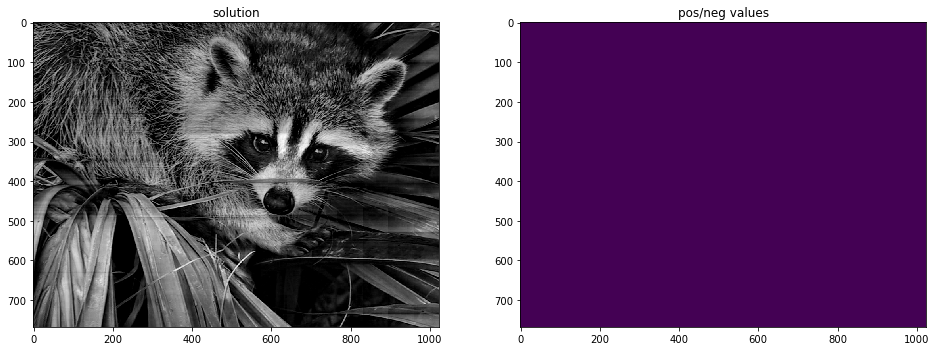

In [5]:
# reshape vectors into 2d fortran-ordered arrays
Y = pfovs.copy().reshape((1,-1)).T
X = np.zeros_like(img).reshape((1,-1)).T

AHy_d = B.copy_array(AHy)

def proxg(x_d, alpha):
    B.max(0, x_d)
    
def gradf(gf, x):
    # gf = AHA*x - AHy
    AHA.eval(gf, x)
    B.axpby(1, gf, -1, AHy_d)

alpha = 0.05
with Timer() as t:
    B.apgd(gradf, proxg, alpha, X, maxiter=200)

print("reconstruction took %d ms" % (t.elapsed*1000))

img_rec = X.T.reshape(img.shape)
fig, (ax0, ax1) = plt.subplots(1,2,figsize=(16,16))
ax0.set_title('solution')
ax0.imshow(abs(img_rec), cmap='gray', interpolation='none')
ax1.set_title('pos/neg values')
ax1.imshow(img_rec.real < 0)